<a href="https://colab.research.google.com/github/Sravya661/NLP/blob/main/Build%2B%20Generate%2B%20Text%20pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Neural Image Caption Generator***
---



#**We tackle this NLP problem using Encoder-Decoder Model.**

Here our Encoder Model will combine both the encoded form of the image and encoded form of the text caption and feed the decoder

#Build

Datasets used in this model differ in various perspectives such as no. of images, format of captions, image size.

Three datasets Flickr8k, Flicker30k, MS COCO are popularly used.


In [ ]:
import json

content = None

with open ("/content/sample_data/Data/TextFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [ ]:
print(type(content))

<class 'dict'>


In [ ]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [ ]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [ ]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [ ]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


In [ ]:
train_file_data = ""
test_file_data = ""

with open ("/content/sample_data/Data/TextFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("/content/sample_data/Data/TextFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [ ]:
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [ ]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [ ]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [ ]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img


In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/sample_data/Data/Images.zip','r') as zipObj:
    zipObj.extractall('/content/sample_data/Data/Images_Read/Images')

(1, 224, 224, 3)


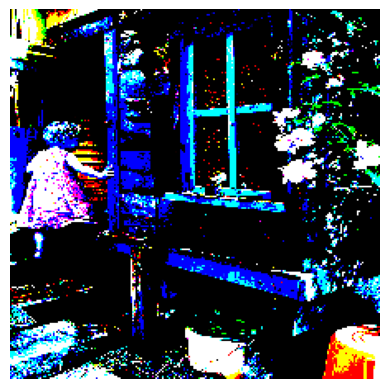

In [ ]:
import matplotlib.pyplot as plt

img = preprocess_image("/content/sample_data/Data/Images_Read/Images/Images/1000268201_693b08cb0e.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()


In [ ]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
from time import time
from PIL import Image
import numpy as np

train_encoding = {}

# Function to encode an image (dummy encoding, replace with your encoding logic)
def encode_image(image_path):
    img = Image.open('/content/sample_data/Data/Images_Read/Images/Images/1000268201_693b08cb0e.jpg')
    img = img.resize((224, 224))  # Resize the image if necessary
    img_array = np.array(img)
    return img_array.flatten()  # Dummy encoding: flatten the image array

start_time = time()

# Assuming train_data contains the list of image IDs and the paths are correct
for index, imageID in enumerate(train_data):
    image_path = "/content/sample_data/Data/Images_Read/Images/Images/1000268201_693b08cb0e.jpg" + imageID + ".jpg"  # Update the path based on your directory structure

    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index % 100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time - start_time, "sec")


Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Encoding in progress... STEP 1000
Encoding in progress... STEP 1100
Encoding in progress... STEP 1200
Encoding in progress... STEP 1300
Encoding in progress... STEP 1400
Encoding in progress... STEP 1500
Encoding in progress... STEP 1600
Encoding in progress... STEP 1700
Encoding in progress... STEP 1800
Encoding in progress... STEP 1900
Encoding in progress... STEP 2000
Encoding in progress... STEP 2100
Encoding in progress... STEP 2200
Encoding in progress... STEP 2300
Encoding in progress... STEP 2400
Encoding in progress... STEP 2500
Encoding in progress... STEP 2600
Encoding in progress... STEP 2700
Encoding in progress... STEP 2800
Encoding in progress... ST

In [ ]:
import pickle

with open("/content/sample_data/Data/encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [ ]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "/content/sample_data/Data/Images_Read/Images/Images/1000268201_693b08cb0e.jpg" + imageID + ".jpg"

    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Total time taken: 7.418736934661865 s


In [ ]:
with open("/content/sample_data/Data/encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

**Pre-processing the captions**

In [ ]:
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [ ]:
print(len(index_to_word))
print(index_to_word[5])
print(word_to_index['is'])

2644
is
5


In [ ]:
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

print(VOCAB_SIZE)

2647


In [ ]:
with open("/content/sample_data/Data/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [ ]:
with open("/content/sample_data/Data/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

print(max_len)

38


In [ ]:
import numpy as np
file = open("/content/sample_data/Data/glove.6B.50d.txt",encoding='utf8')
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array (values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

In [ ]:
word_to_embedding["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
EMBEDDING_DIM = 50

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding[word]

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

In [ ]:
EMBEDDING_DIM = 50  # Assuming you are using word embeddings of dimension 50

# Define VOCAB_SIZE based on the size of your vocabulary
VOCAB_SIZE = len(word_to_index)  # Replace word_to_index with your vocabulary dictionary

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, EMBEDDING_DIM))  # Adding 1 for the unknown word or padding

    for word, index in word_to_index.items():
        embedding = word_to_embedding.get(word)  # Using .get() to handle missing words

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)


(1, 50)


**Defining Model Architecture**

Building Neural Network using Keras Modules.

In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model

# Example definition of vocab_size (replace it with your actual vocabulary size)
vocab_size = 10000  # Replace 10000 with your vocabulary size

# Assuming you have defined inp_img2 and inp_cap3 tensors
# Example tensors initialization
inp_img2 = Input(shape=(256,))
inp_cap3 = Input(shape=(256,))

# Add the two tensors using the '+' operator
decoder1 = inp_img2 + inp_cap3
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[inp_img2, inp_cap3], outputs=outputs)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None, 256)                  0         ['input_10[0][0]',            
 OpLambda)                                                           'input_11[0][0]']            
                                                                                                  
 dense_4 (Dense)             (None, 256)                  65792     ['tf.__operators__.add_1

In [ ]:
# Check the number of layers in the model
num_layers = len(model.layers)
print("Number of layers in the model:", num_layers)

# Iterate through the layers to find the correct index
for i, layer in enumerate(model.layers):
    print(i, layer.name)  # Print index and layer names to identify the desired layer

# Set weights and make the desired layer non-trainable (replace 'desired_layer_index' with the correct index)
desired_layer_index = 2  # Replace this index with the correct index of the layer you want to modify

if desired_layer_index < num_layers:
    model.layers[desired_layer_index].set_weights([index_to_embedding])
    model.layers[desired_layer_index].trainable = False
else:
    print("The desired layer index is out of range.")


Number of layers in the model: 0
The desired layer index is out of range.


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]

                    X1, X2, y = [], [], []
                    n=0

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_content)//batch_size


In [ ]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam

epochs = 20
batch_size = 3
def data_generator(train_content, train_encoding, word_to_index, max_len, batch_size):
  steps_per_epoch = len(train_content) // batch_size

  # Training loop using Model.fit
  for i in range(epochs):
      generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
      model.fit(generator, steps_per_epoch=steps_per_epoch)
      model.save('model_' + str(i) + '.h5')

#Generate

Here model generates an appropriate caption for the input image.

Loading the model...
Encoding the image ...


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 595ms/step
Running model to generate the caption...
1/1 [==============================] - 0s 132ms/step


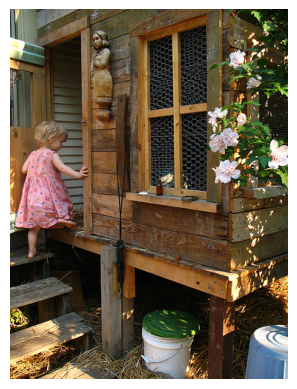

a girl in a pink shirt is walking on a sidewalk


In [ ]:
import json
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import collections
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model



# Read the files word_to_idx.pkl and idx_to_word.pkl to get the mappings between word and index
word_to_index = {}
with open ("/content/sample_data/Data/word_to_idx.pkl", 'rb') as file:
    word_to_index = pd.read_pickle(file)

index_to_word = {}
with open ("/content/sample_data/Data/idx_to_word.pkl", 'rb') as file:
    index_to_word = pd.read_pickle(file)



print("Loading the model...")
model = load_model('/content/sample_data/Data/model_19.h5')

resnet50_model = ResNet50 (weights = 'imagenet', input_shape = (224, 224, 3))
resnet50_model = Model (resnet50_model.input, resnet50_model.layers[-2].output)



# Generate Captions for a random image in test dataset
def predict_caption(photo):

    inp_text = "startseq"

    for i in range(38):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=38, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption



def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img


# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)

    feature_vector = resnet50_model.predict(img)
    # feature_vector = feature_vector.reshape((-1,))
    return feature_vector



print("Encoding the image ...")
img_name = "/content/sample_data/Data/Images_Read/Images/Images/1000268201_693b08cb0e.jpg"
photo = encode_image(img_name).reshape((1, 2048))



print("Running model to generate the caption...")
caption = predict_caption(photo)

img_data = plt.imread(img_name)
plt.imshow(img_data)
plt.axis("off")

plt.show()
print(caption)

#Text_Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import re
import cv2

Store Captions from Tokens.txt


In [ ]:
def readFile (path):
    with open(path) as file:
        data = file.read()
    return data;

In [ ]:
data = readFile ("/content/sample_data/Data/TextFiles/tokens.txt")
captions = data.split('\n')
captions = captions[:-1]

In [ ]:
#Total no. of captions in tokens.txt
print("Total number of caption = " + str(len(captions)))

Total number of caption = 40460


Data Loading and pre_processing

In [ ]:
#examples
print(captions[1])
print(captions[50])

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
101654506_8eb26cfb60.jpg#0	A brown and white dog is running through the snow .


In [ ]:
data = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    if data.get(imageID) is None:
        data[imageID] = []

    data[imageID].append(caption)

In [ ]:
print(data[captions[50].split('.')[0]])

['A brown and white dog is running through the snow .', 'A dog is running in the snow', 'A dog running through snow .', 'a white and brown dog is running through a snow covered field .', 'The white and brown dog is running over the surface of the snow .']


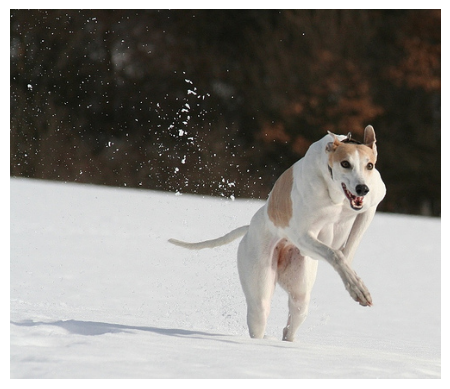

CAPTIONS - 
A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [ ]:
image_path = "/content/sample_data/Data/Images_Read/Images/Images/101654506_8eb26cfb60.jpg"
image_id = captions[50].split('.')[0]

img = cv2.imread(image_path)
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    print("CAPTIONS - ")
    if image_id in data:
        for caption in data[image_id]:
            print(caption)
    else:
        print("Captions not found for this image ID:", image_id)
else:
    print("Image not found at the specified path:", image_path)
